## Loading Dependencies

In [363]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import zscore

from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import cross_val_score


import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [364]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [365]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sample_data/df_95_labeled_on_lift.csv')
df2= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sample_data/df_310_labeled_on_lift_v4.csv')

In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5717 entries, 0 to 5716
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 5717 non-null   object 
 1   accelX(g)                 5717 non-null   float64
 2   accelY(g)                 5717 non-null   float64
 3   accelZ(g)                 5717 non-null   float64
 4   accelUserX(g)             5717 non-null   float64
 5   accelUserY(g)             5717 non-null   float64
 6   accelUserZ(g)             5717 non-null   float64
 7   gyroX(rad/s)              5717 non-null   float64
 8   gyroY(rad/s)              5717 non-null   float64
 9   gyroZ(rad/s)              5717 non-null   float64
 10  Roll(rads)                5717 non-null   float64
 11  Pitch(rads)               5717 non-null   float64
 12  Yaw(rads)                 5717 non-null   float64
 13  m11                       5717 non-null   float64
 14  m12     

In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5717 entries, 0 to 5716
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 5717 non-null   object 
 1   accelX(g)                 5717 non-null   float64
 2   accelY(g)                 5717 non-null   float64
 3   accelZ(g)                 5717 non-null   float64
 4   accelUserX(g)             5717 non-null   float64
 5   accelUserY(g)             5717 non-null   float64
 6   accelUserZ(g)             5717 non-null   float64
 7   gyroX(rad/s)              5717 non-null   float64
 8   gyroY(rad/s)              5717 non-null   float64
 9   gyroZ(rad/s)              5717 non-null   float64
 10  Roll(rads)                5717 non-null   float64
 11  Pitch(rads)               5717 non-null   float64
 12  Yaw(rads)                 5717 non-null   float64
 13  m11                       5717 non-null   float64
 14  m12     

In [368]:
# Convert 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'])


In [369]:
#df_l = df.drop(columns=['ActivityType', 'ActivityConfidence', 'Pressure(kilopascals)', 'Roll(rads)', 'Pitch(rads)', 'Yaw(rads)', 'Cluster_1'],inplace=True)

In [370]:
df.shape


(5717, 46)

In [371]:
df2.shape

(18577, 46)

In [372]:
# Check for duplicates
duplicate_ids = (df["Timestamp"].value_counts() > 1).sum()
duplicate_ids

0

In [373]:
# Check for duplicates
duplicate_ids = (df2["Timestamp"].value_counts() > 1).sum()
duplicate_ids

0

In [374]:
# Display the first few rows to verify the conversion
print(df['Timestamp'].head())


0   2023-04-07 09:13:51.953
1   2023-04-07 09:13:52.957
2   2023-04-07 09:13:53.961
3   2023-04-07 09:13:54.965
4   2023-04-07 09:13:55.969
Name: Timestamp, dtype: datetime64[ns]


In [375]:
# Removing NaN values
df.dropna(inplace=True)
df.shape

(5717, 46)

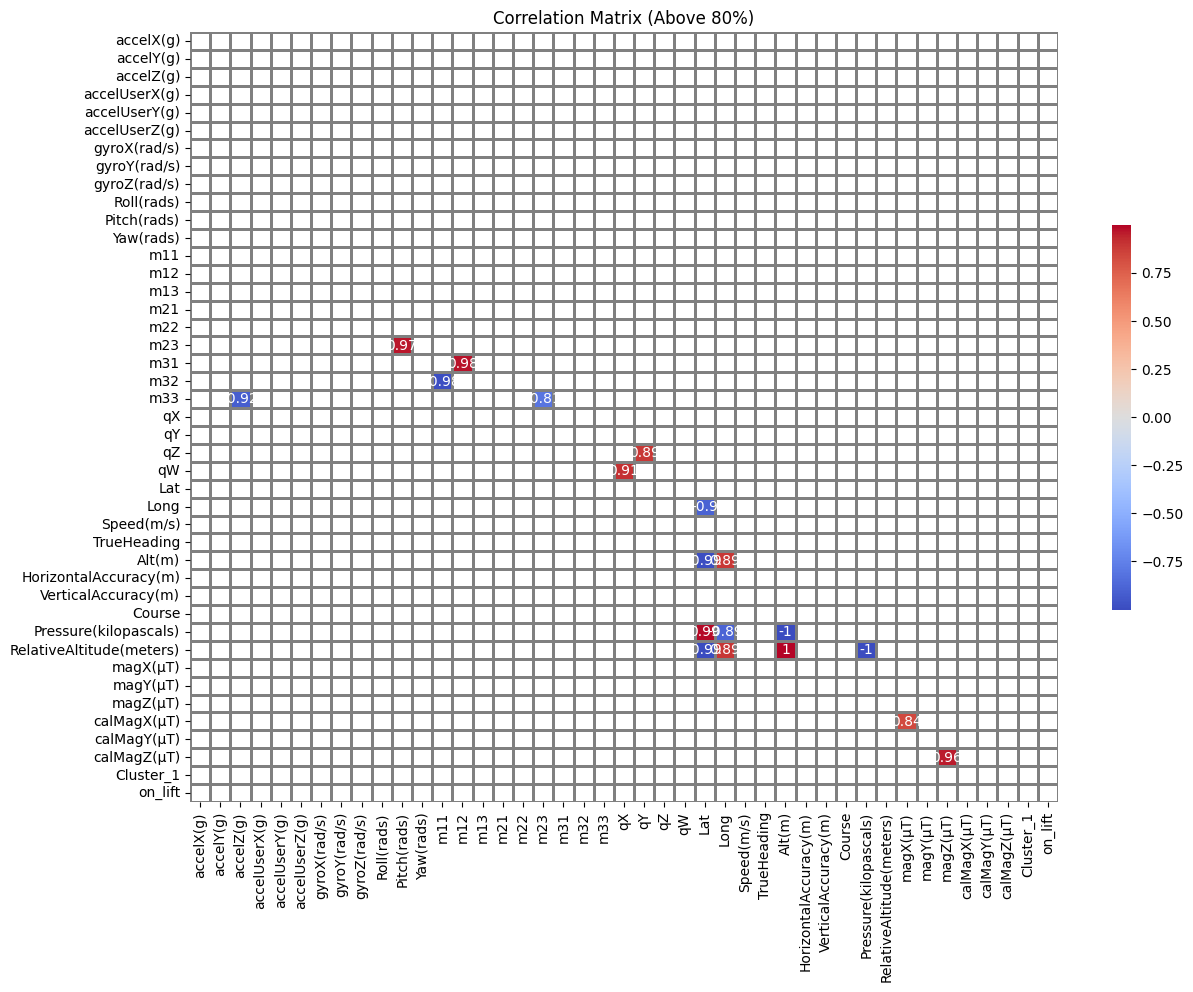

In [376]:
# correlation matrix with 44 features
corr_matrix = df.corr()

# Create a mask for the upper triangle and for correlations below 0.8 in absolute value
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) | (np.abs(corr_matrix) < 0.8)

plt.figure(figsize=(14, 10))
# Adjust linewidths and linecolor for better readability
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', linewidths=1, linecolor='gray', cbar_kws={"shrink": .5})
plt.title('Correlation Matrix (Above 80%)')
plt.show()

In [377]:
df.describe()

,accelX(g),accelY(g),accelZ(g),accelUserX(g),accelUserY(g),accelUserZ(g),gyroX(rad/s),gyroY(rad/s),gyroZ(rad/s),Roll(rads),...,Pressure(kilopascals),RelativeAltitude(meters),magX(µT),magY(µT),magZ(µT),calMagX(µT),calMagY(µT),calMagZ(µT),Cluster_1,on_lift
count,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,...,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000,5717.000000
mean,0.090931,-0.919209,-0.059333,0.000045,-0.020865,0.005933,0.019539,0.013699,0.010264,0.877133,...,77.398415,785.844389,-131.298608,45.105683,-48.237798,-9.708961,-5.911841,2.746117,0.589470,0.249781
std,0.245091,0.256684,0.361780,0.235390,0.203535,0.142512,0.306080,0.468037,0.284150,1.780262,...,4.836506,499.393834,19.628722,11.229571,22.859260,24.940830,26.786143,25.649104,1.168717,0.432924
min,-1.110900,-2.621500,-1.660700,-1.495500,-1.833100,-1.202800,-2.880500,-3.112300,-5.427900,-3.140400,...,70.338200,-3.038600,-212.177800,-17.868600,-140.709000,-79.455800,-91.693800,-95.045900,-1.000000,0.000000
25%,-0.017000,-0.997200,-0.139600,-0.023700,-0.021600,-0.017400,-0.049300,-0.096000,-0.047400,-0.008200,...,73.155500,557.447600,-143.933700,37.458000,-66.097400,-27.275400,-32.522400,-17.726500,0.000000,0.000000
50%,0.076200,-0.969100,0.064900,-0.000500,-0.000100,0.000600,0.008400,0.004200,0.006900,1.201800,...,77.288300,784.637000,-128.455400,44.623000,-49.275600,-8.931500,2.560000,1.618800,0.000000,0.000000
75%,0.181900,-0.897800,0.169900,0.021500,0.019400,0.022700,0.074600,0.115900,0.061400,2.364300,...,79.505500,1222.585400,-116.241800,52.210600,-30.389200,10.768800,17.824200,20.261200,2.000000,0.000000
max,2.189300,0.507700,0.960900,2.109800,1.154700,1.096100,4.573000,8.225200,2.010600,3.141200,...,85.196400,1532.764900,-79.923300,152.416700,22.013500,48.409400,78.647200,77.846900,3.000000,1.000000


In [378]:
# Scaling the features before plotting
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_cols])
df_scaled_numeric = pd.DataFrame(scaled_features, columns=numeric_cols)
df_scaled = df.copy()
df_scaled[numeric_cols] = df_scaled_numeric


In [379]:
# Scaling the features before plotting
numeric_cols2 = df2.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
scaled_features2 = scaler.fit_transform(df2[numeric_cols2])
df_scaled_numeric2 = pd.DataFrame(scaled_features2, columns=numeric_cols2)
df_scaled2 = df2.copy()
df_scaled2[numeric_cols] = df_scaled_numeric2

Text(0.5, 0.98, 'Histograms of Numeric Features')

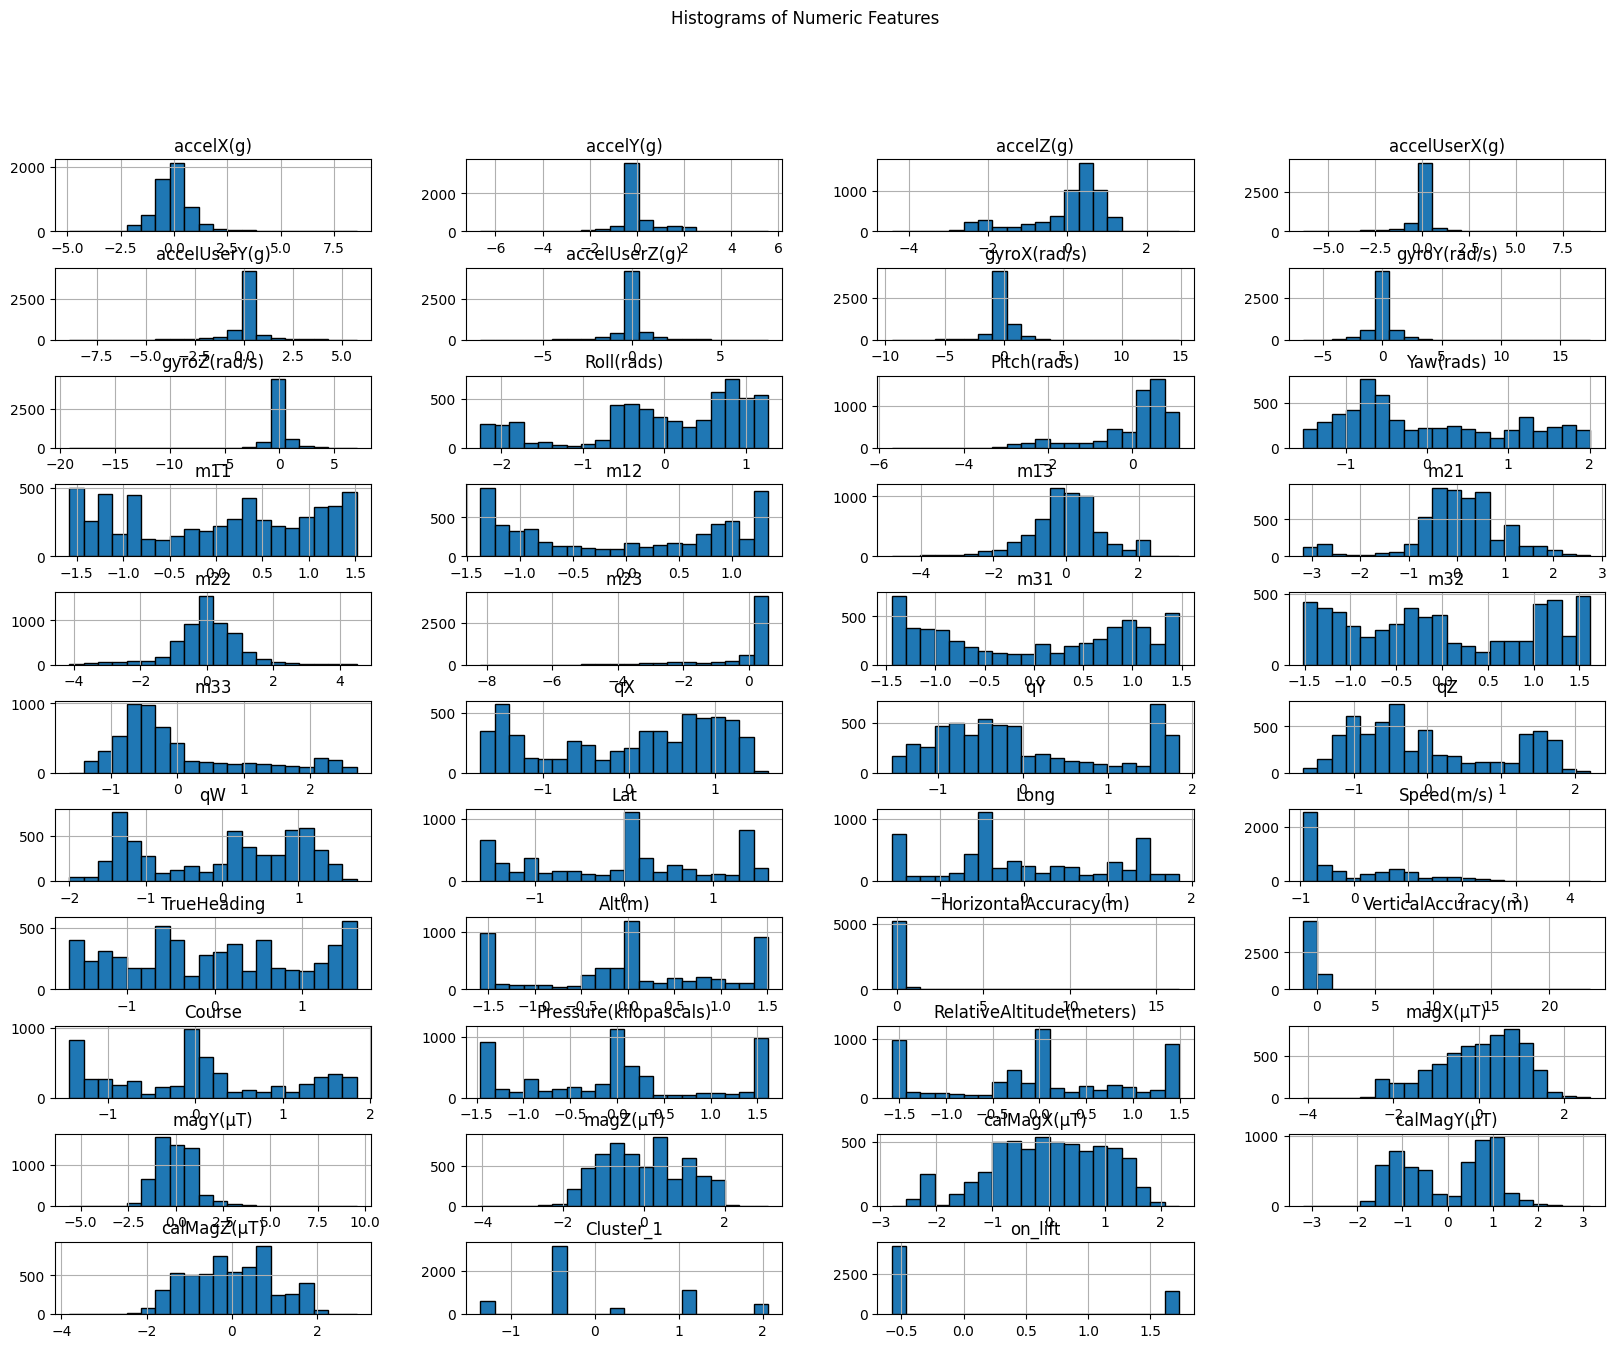

In [380]:
# Select and plot histograms for numeric columns
numeric_cols = df_scaled.select_dtypes(include=[np.number])
numeric_cols.hist(figsize=(20, 15), bins=20, edgecolor='black', layout=(-1, 4))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle('Histograms of Numeric Features')


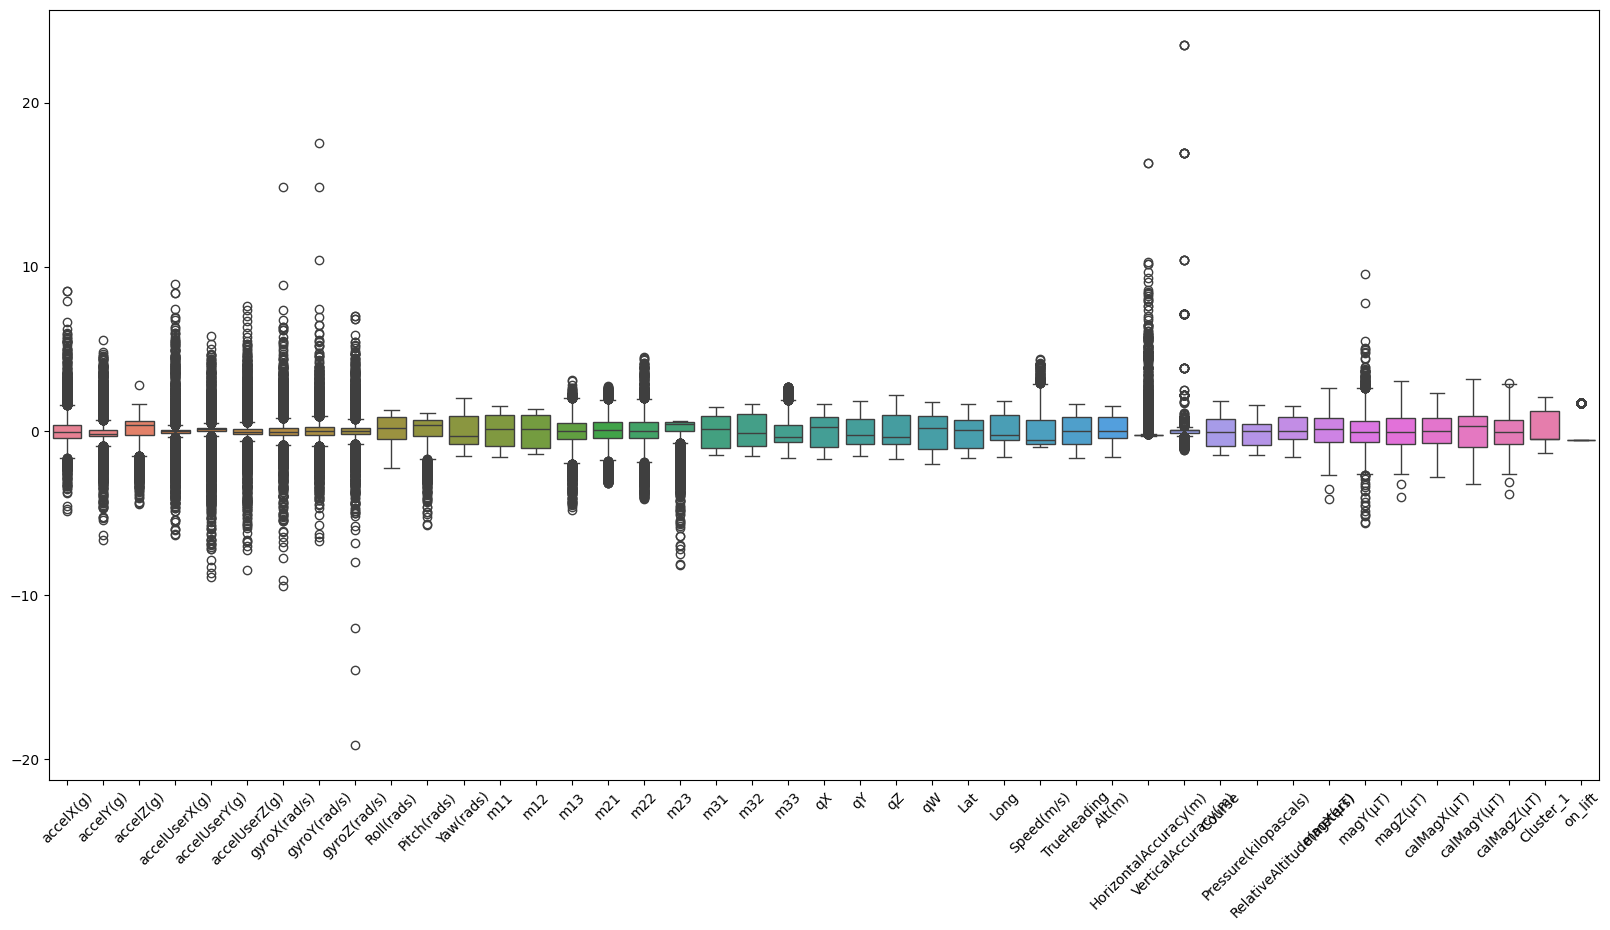

In [381]:
# Boxplots for each feature
plt.figure(figsize=(20, 10)) # these values are more suitable for time-series data
ax = sns.boxplot(data=df_scaled)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [382]:
# List of columns to check for outliers
sensor_columns = [
    'accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)',
    'accelUserY(g)', 'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)',
    'gyroZ(rad/s)', 'm11', 'm12', 'm13', 'm21', 'm22', 'm23', 'm31', 'm32',
    'm33', 'qX', 'qY', 'qZ', 'qW'
]

# Calculate Z-scores
z_scores = df[sensor_columns].apply(zscore)

# Define a threshold for identifying outliers
threshold = 3

# Get boolean mask where true indicates the presence of an outlier
outliers = (np.abs(z_scores) > threshold).any(axis=1)

# Remove outliers
df_clean = df[~outliers]

# Shape of the dataframe before and after outlier removal
df.shape, df_clean.shape



((5717, 46), (4974, 46))

In [383]:
# List of columns to check for outliers
sensor_columns2 = [
    'accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)',
    'accelUserY(g)', 'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)',
    'gyroZ(rad/s)', 'm11', 'm12', 'm13', 'm21', 'm22', 'm23', 'm31', 'm32',
    'm33', 'qX', 'qY', 'qZ', 'qW'
]

# Calculate Z-scores
z_scores2 = df2[sensor_columns2].apply(zscore)

# Define a threshold for identifying outliers
threshold = 3

# Get boolean mask where true indicates the presence of an outlier
outliers2 = (np.abs(z_scores2) > threshold).any(axis=1)

# Remove outliers
df_clean2 = df2[~outliers2]

# Shape of the dataframe before and after outlier removal
df2.shape, df_clean2.shape



((18577, 46), (16418, 46))

In [384]:
df_features= ['accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)','accelUserY(g)',
'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)','gyroZ(rad/s)', 'm11', 'm12', 'm13',
'm21', 'm22', 'm23', 'm31', 'm32','m33', 'qX', 'qY', 'qZ', 'qW', 'Lat', 'Long', 'Speed(m/s)',
'TrueHeading', 'Alt(m)', 'HorizontalAccuracy(m)', 'VerticalAccuracy(m)',
'Course', 'RelativeAltitude(meters)', 'magX(µT)', 'magY(µT)',
'magZ(µT)', 'calMagX(µT)', 'calMagY(µT)', 'calMagZ(µT)']

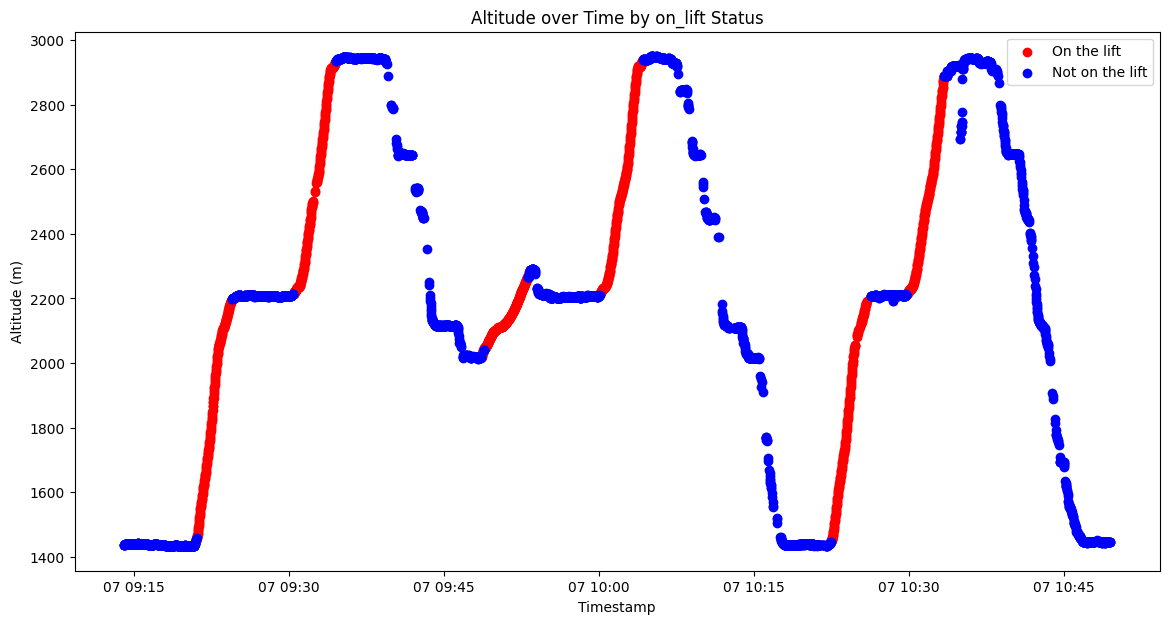

In [385]:
# Plot for Altitude over Time, colored by 'on_lift' status
plt.figure(figsize=(14, 7))

# Plot points where 'on_lift' is 1 with one color
plt.scatter(df_clean.loc[df['on_lift'] == 1, 'Timestamp'],
            df_clean.loc[df['on_lift'] == 1, 'Alt(m)'],
            c='red',
            label='On the lift',
            marker='o')

# Plot points where 'on_lift' is 0 with another color
plt.scatter(df_clean.loc[df['on_lift'] == 0, 'Timestamp'],
            df_clean.loc[df['on_lift'] == 0, 'Alt(m)'],
            c='blue',
            label='Not on the lift',
            marker='o')

plt.title('Altitude over Time by on_lift Status')
plt.xlabel('Timestamp')
plt.ylabel('Altitude (m)')
plt.legend()
plt.show()

In [ ]:
X = df_clean[df_features]
y = df_clean['on_lift']

In [ ]:
# stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train.shape, X_test.shape

((3481, 37), (1493, 37))

In [ ]:
# Create a pipeline
pipeline_df = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
                                      max_iter=1000
                                     ))
])

# Fit the pipeline to the training data
pipeline_df.fit(X_train, y_train)

# Predict on the test data
y_pred_features = pipeline_df.predict(X_test)

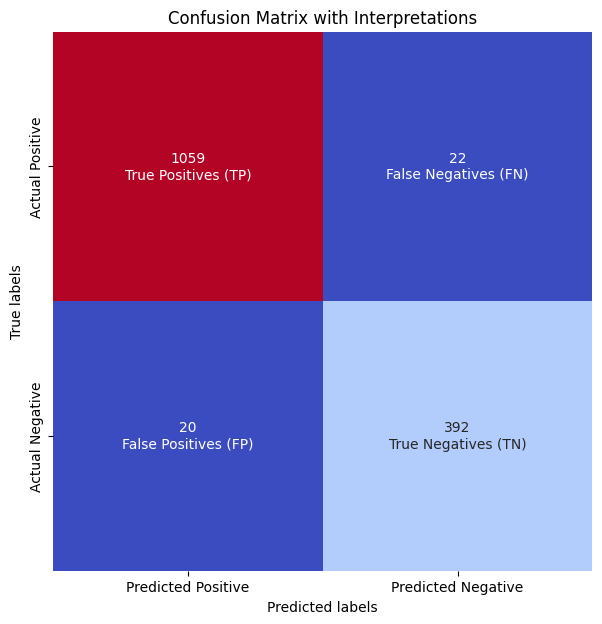

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_features)

# Creating annotations with TP, TN, FP, FN labels
labels = np.array([['True Positives (TP)', 'False Negatives (FN)'],
                   ['False Positives (FP)', 'True Negatives (TN)']])
annot = np.asarray([f"{val}\n{labels[i, j]}" for i, j, val in zip(*conf_mat.nonzero(), conf_mat.flatten())]).reshape(2,2)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=annot, fmt='', cmap='coolwarm', cbar=False, square=True,
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Interpretations')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_features))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1081
           1       0.95      0.95      0.95       412

    accuracy                           0.97      1493
   macro avg       0.96      0.97      0.96      1493
weighted avg       0.97      0.97      0.97      1493



In [ ]:
# Define the cross-validation strategy
# Calculate cross-validated scores for the pipeline
cv_scores = cross_val_score(pipeline_df, X_train, y_train, cv=3, scoring='f1')

# Print the mean F1 score and the 95% confidence interval of the score estimate
print("Mean CV F1 Score: %0.2f" % cv_scores.mean())

Mean CV F1 Score: 0.95


**Random Search for Hyper-parameter tuning**

In [ ]:
# Define the parameter grid to search, with the prefix 'classifier__' for the logistic regression parameters
param_distributions = {
    'classifier__C': uniform(0.01, 10),  # Regularization parameter
    'classifier__penalty': ['l2', 'none'],  # The norm of the penalty
    'classifier__solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']  # Algorithm to use in the optimization problem
}

# Create RandomizedSearchCV object with the pipeline and the parameter grid
random_search = RandomizedSearchCV(
    estimator=pipeline_df,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              LogisticRegression(max_iter=1000))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e509972b880>,
                                        'classifier__penalty': ['l2', 'none'],
                                        'classifier__solver': ['newton-cg',
                                                               'lbfgs', 'sag',
                                                               'saga',
                                                               'liblinear']},
                   scoring='f1', verbose=1)

In [ ]:
# Print the best parameters and the corresponding F1 score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)


Best Parameters: {'classifier__C': 7.025118681436823, 'classifier__penalty': 'none', 'classifier__solver': 'newton-cg'}
Best F1 Score: 0.9558178737081877


In [ ]:
# Retrieve the best model from random search
best_pipeline = random_search.best_estimator_


In [ ]:
# Predict on the test data with the best model
y_pred_features_best = best_pipeline.predict(X_test)


In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier',
   LogisticRegression(C=7.025118681436823, max_iter=1000, penalty='none',
                      solver='newton-cg'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': LogisticRegression(C=7.025118681436823, max_iter=1000, penalty='none',
                    solver='newton-cg'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 7.025118681436823,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 1000,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'none',
 'classifier__random_state': None,
 'classifier__solver': 'newton-cg',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [ ]:

# Get the detailed results for all the model fits
cv_results = random_search.cv_results_

# Convert to a DataFrame for easier viewing
cv_results_df = pd.DataFrame(cv_results)

important_columns = ['rank_test_score', 'mean_test_score', 'std_test_score', 'params']
cv_results_df = cv_results_df[important_columns].sort_values(by='rank_test_score')

print(cv_results_df)


   rank_test_score  mean_test_score  std_test_score  \
3                1         0.955818        0.005892   
4                2         0.953072        0.005957   
2                3         0.952979        0.004719   
8                3         0.952979        0.004719   
0                5         0.952534        0.005223   
9                5         0.952534        0.005223   
7                7         0.952038        0.004553   
1                8         0.951499        0.004762   
5                9         0.951451        0.003591   
6               10         0.946779        0.002439   

                                              params  
3  {'classifier__C': 7.025118681436823, 'classifi...  
4  {'classifier__C': 3.351223133918969, 'classifi...  
2  {'classifier__C': 6.501872648116189, 'classifi...  
8  {'classifier__C': 0.596486417818386, 'classifi...  
0  {'classifier__C': 2.6205326281349706, 'classif...  
9  {'classifier__C': 6.134434795002276, 'classifi...  
7  {'clas

**Repeat for 310 dataset**

In [ ]:
df_clean2.shape

(16418, 42)

In [ ]:
df_clean2.columns

Index(['Timestamp', 'accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)',
       'accelUserY(g)', 'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)',
       'gyroZ(rad/s)', 'm11', 'm12', 'm13', 'm21', 'm22', 'm23', 'm31', 'm32',
       'm33', 'qX', 'qY', 'qZ', 'qW', 'Lat', 'Long', 'Speed(m/s)',
       'TrueHeading', 'Alt(m)', 'HorizontalAccuracy(m)', 'VerticalAccuracy(m)',
       'Course', 'RelativeAltitude(meters)', 'magX(µT)', 'magY(µT)',
       'magZ(µT)', 'calMagX(µT)', 'calMagY(µT)', 'calMagZ(µT)', 'on_lift',
       'Speed_change', 'Altitude_change', 'Course_change'],
      dtype='object')

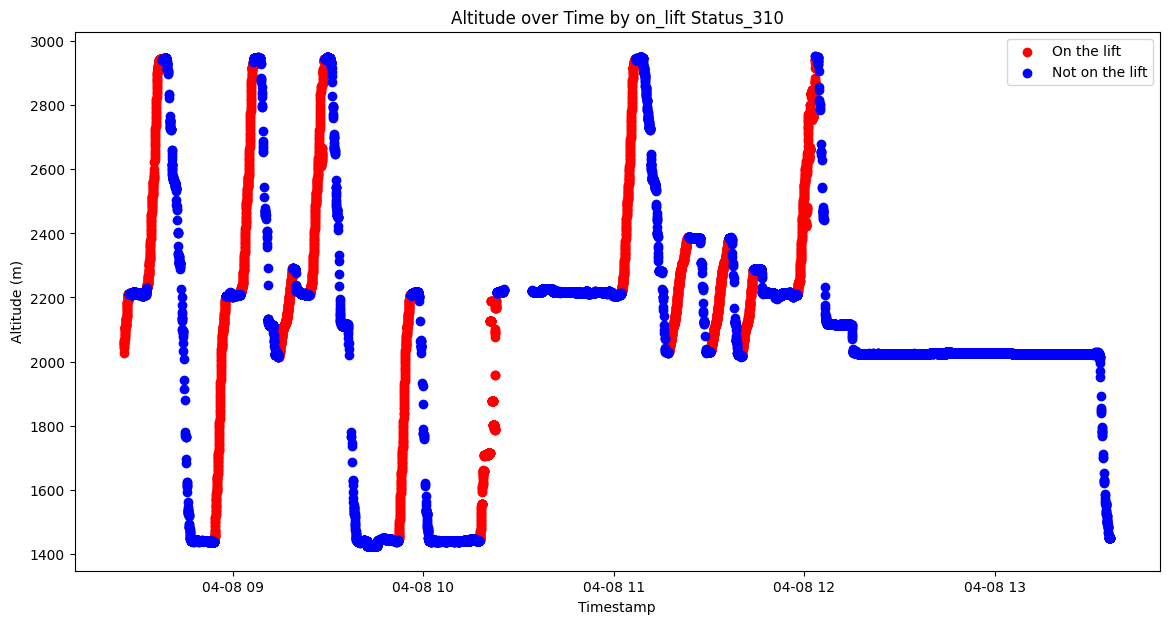

In [ ]:
# Plot for Altitude over Time, colored by 'on_lift' status
plt.figure(figsize=(14, 7))

# Plot points where 'on_lift' is 1 with one color
plt.scatter(df_clean2.loc[df_clean2['on_lift'] == 1, 'Timestamp'],
            df_clean2.loc[df_clean2['on_lift'] == 1, 'Alt(m)'],
            c='red',
            label='On the lift',
            marker='o')

# Plot points where 'on_lift' is 0 with another color
plt.scatter(df_clean2.loc[df_clean2['on_lift'] == 0, 'Timestamp'],
            df_clean2.loc[df_clean2['on_lift'] == 0, 'Alt(m)'],
            c='blue',
            label='Not on the lift',
            marker='o')

plt.title('Altitude over Time by on_lift Status_310')
plt.xlabel('Timestamp')
plt.ylabel('Altitude (m)')
plt.legend()
plt.show()

In [ ]:
drop_col=['on_lift', 'Timestamp']
X = df_clean2.drop(columns=drop_col)

y = df_clean2['on_lift']


# stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train.shape, X_test.shape

((11492, 40), (4926, 40))

In [ ]:
# Create a pipeline
pipeline_df2 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=9.96282700296736, max_iter=1000, penalty='l2',
                      solver='sag'))
])

# Fit the pipeline to the training data
pipeline_df2.fit(X_train, y_train)

# Predict on the test data
y_pred_features2 = pipeline_df2.predict(X_test)

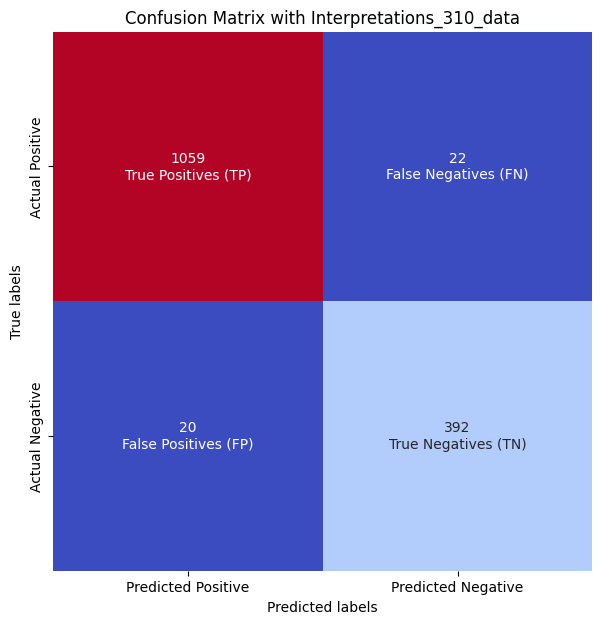

In [ ]:
conf_mat2 = confusion_matrix(y_test, y_pred_features2)

# Creating annotations with TP, TN, FP, FN labels
labels = np.array([['True Positives (TP)', 'False Negatives (FN)'],
                   ['False Positives (FP)', 'True Negatives (TN)']])
annot = np.asarray([f"{val}\n{labels[i, j]}" for i, j, val in zip(*conf_mat.nonzero(), conf_mat.flatten())]).reshape(2,2)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=annot, fmt='', cmap='coolwarm', cbar=False, square=True,
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Interpretations_310_data')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_features2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3886
           1       0.89      0.88      0.89      1040

    accuracy                           0.95      4926
   macro avg       0.93      0.93      0.93      4926
weighted avg       0.95      0.95      0.95      4926



In [ ]:
# Define the cross-validation strategy
# Calculate cross-validated scores for the pipeline
cv_scores2 = cross_val_score(pipeline_df2, X_train, y_train, cv=3, scoring='f1')

# Print the mean F1 score and the 95% confidence interval of the score estimate
print("Mean CV F1 Score: %0.2f" % cv_scores2.mean())

Mean CV F1 Score: 0.87


**Engineered-features**

In [ ]:
  # Calculate change in speed
df_clean2['Speed_change'] = df_clean2['Speed(m/s)'].diff().fillna(0)

  # Calculate the altitude difference between consecutive points
df_clean2['Altitude_change'] = df_clean2['Alt(m)'].diff().fillna(0)

  # Calculate the
df_clean2['Course_change'] = df_clean2['Course'].diff().fillna(0)

  #df_clean2

**Replace features with engineered features**

In [ ]:
drop_col2=['on_lift', 'Timestamp', 'Alt(m)', 'Speed(m/s)','Course']
X = df_clean2.drop(columns=drop_col2)

y = df_clean2['on_lift']


# stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train.shape, X_test.shape

((11492, 37), (4926, 37))

In [ ]:
# Create a pipeline
pipeline_df3 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=9.859318620326988, max_iter=1000, penalty='l2',
                      solver='sag'))
])

# Fit the pipeline to the training data
pipeline_df3.fit(X_train, y_train)

# Predict on the test data
y_pred_features3 = pipeline_df3.predict(X_test)

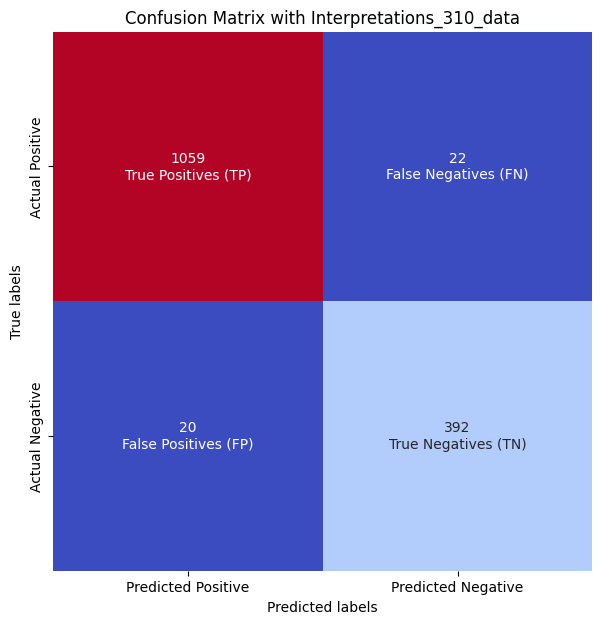

In [ ]:
conf_mat3 = confusion_matrix(y_test, y_pred_features3)

# Creating annotations with TP, TN, FP, FN labels
labels = np.array([['True Positives (TP)', 'False Negatives (FN)'],
                   ['False Positives (FP)', 'True Negatives (TN)']])
annot = np.asarray([f"{val}\n{labels[i, j]}" for i, j, val in zip(*conf_mat.nonzero(), conf_mat.flatten())]).reshape(2,2)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=annot, fmt='', cmap='coolwarm', cbar=False, square=True,
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Interpretations_310_data')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_features3))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3886
           1       0.87      0.84      0.85      1040

    accuracy                           0.94      4926
   macro avg       0.91      0.90      0.91      4926
weighted avg       0.94      0.94      0.94      4926



In [ ]:
# Define the cross-validation strategy
# Calculate cross-validated scores for the pipeline
cv_scores3 = cross_val_score(pipeline_df3, X_train, y_train, cv=3, scoring='f1')

# Print the mean F1 score and the 95% confidence interval of the score estimate
print("Mean CV F1 Score: %0.2f" % cv_scores3.mean())

Mean CV F1 Score: 0.85


**Reduce features**

In [ ]:
drop_col3=['on_lift', 'Timestamp', 'Alt(m)', 'Speed(m/s)','Course',
           'accelUserX(g)','accelUserY(g)', 'accelUserZ(g)','m11', 'm12','m13', 'm21',
           'm22', 'm23', 'm31', 'm32', 'm33', 'qX', 'qY', 'qZ', 'qW',
            'TrueHeading', 'HorizontalAccuracy(m)', 'VerticalAccuracy(m)',
            'RelativeAltitude(meters)','calMagX(µT)', 'calMagY(µT)', 'calMagZ(µT)']
X = df_clean2.drop(columns=drop_col3)

y = df_clean2['on_lift']


# stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train.shape, X_test.shape

((11492, 14), (4926, 14))

In [ ]:
# Create a pipeline
pipeline_df4 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=8.06140926401828, max_iter=1000, penalty='none',
                      solver='lbfgs'))
])

# Fit the pipeline to the training data
pipeline_df4.fit(X_train, y_train)

# Predict on the test data
y_pred_features4 = pipeline_df4.predict(X_test)

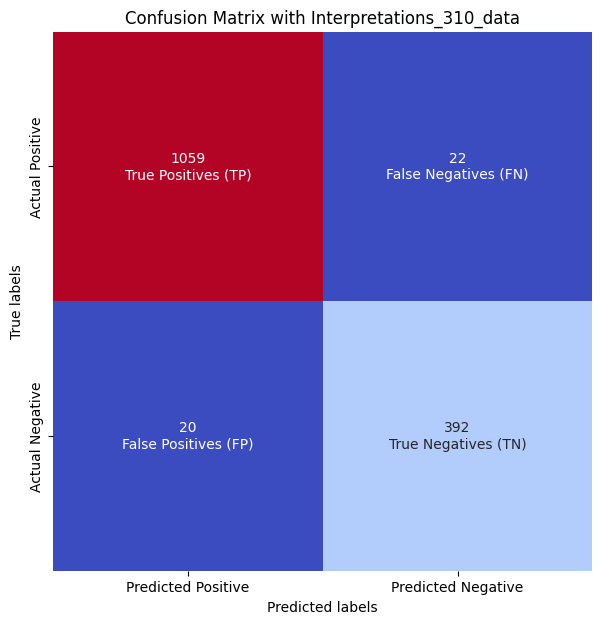

In [ ]:
conf_mat4 = confusion_matrix(y_test, y_pred_features4)

# Creating annotations with TP, TN, FP, FN labels
labels = np.array([['True Positives (TP)', 'False Negatives (FN)'],
                   ['False Positives (FP)', 'True Negatives (TN)']])
annot = np.asarray([f"{val}\n{labels[i, j]}" for i, j, val in zip(*conf_mat.nonzero(), conf_mat.flatten())]).reshape(2,2)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=annot, fmt='', cmap='coolwarm', cbar=False, square=True,
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Interpretations_310_data')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_features4))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3886
           1       0.84      0.64      0.73      1040

    accuracy                           0.90      4926
   macro avg       0.88      0.80      0.83      4926
weighted avg       0.90      0.90      0.89      4926



In [ ]:
# Define the cross-validation strategy
# Calculate cross-validated scores for the pipeline
cv_scores4 = cross_val_score(pipeline_df4, X_train, y_train, cv=3, scoring='f1')

# Print the mean F1 score and the 95% confidence interval of the score estimate
print("Mean CV F1 Score: %0.2f" % cv_scores4.mean())

Mean CV F1 Score: 0.76


**Recursive Feature Elimination using RFECV**

> Indented block



In [ ]:
from sklearn.pipeline import make_pipeline

X = df_clean2[df_features]
y = df_clean2['on_lift']

# Define and fit the pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression(C=9.96282700296736, max_iter=1000, penalty='l2', solver='sag'))
pipeline.fit(X_train, y_train)

logistic_model = pipeline.named_steps['logisticregression']

rfe = RFECV(estimator=logistic_model, step=1, cv=StratifiedKFold(10), scoring='f1')
rfe.fit(X_train, y_train)


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=9.96282700296736, max_iter=1000,
                                   solver='sag'),
      scoring='f1')

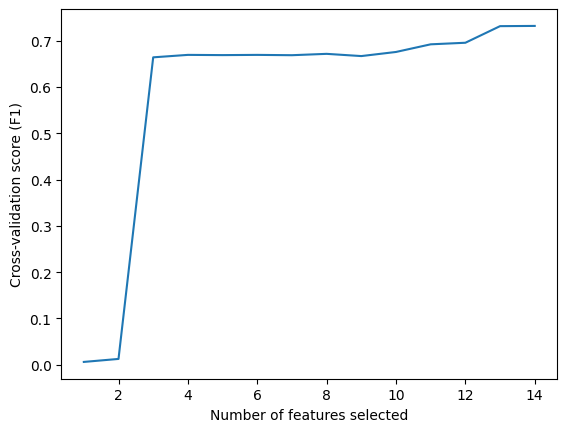

Optimal number of features: 14
Best features: Index(['accelX(g)', 'accelY(g)', 'accelZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)',
       'gyroZ(rad/s)', 'Lat', 'Long', 'magX(µT)', 'magY(µT)', 'magZ(µT)',
       'Speed_change', 'Altitude_change', 'Course_change'],
      dtype='object')


In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (F1)")
plt.plot(range(1, len(rfe.cv_results_['mean_test_score']) + 1), rfe.cv_results_['mean_test_score'])
plt.show()

# Print the optimal number of features and their indices or names
print('Optimal number of features:', rfe.n_features_)
if hasattr(X_train, 'columns'):
    print('Best features:', X_train.columns[rfe.support_])
else:
    print('Best features indices:', rfe.support_)



In [ ]:
import statsmodels.api as sm


cols= ['accelX(g)', 'accelY(g)', 'accelZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)',
       'gyroZ(rad/s)', 'Lat', 'Long', 'magX(µT)', 'magY(µT)', 'magZ(µT)',
       'Speed_change', 'Altitude_change']


# Analysis with original set of features
X = sm.add_constant(df_clean2[cols])  # Add constant for the intercept
y = df_clean2['on_lift']
Logit_model = sm.Logit(y, X)
result = Logit_model.fit()
print(result.summary2())



Optimization terminated successfully.
         Current function value: 0.276426
         Iterations 17
                             Results: Logit
Model:                 Logit               Method:              MLE      
Dependent Variable:    on_lift             Pseudo R-squared:    0.464    
Date:                  2024-02-05 23:47    AIC:                 9104.7264
No. Observations:      16418               BIC:                 9212.6123
Df Model:              13                  Log-Likelihood:      -4538.4  
Df Residuals:          16404               LL-Null:             -8463.5  
Converged:             1.0000              LLR p-value:         0.0000   
No. Iterations:        17.0000             Scale:               1.0000   
-------------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|    [0.025     0.975]  
-------------------------------------------------------------------------
const           -2392.9930 300.3814  -7

In [ ]:
# Analysis after feature selection
cols2 = ['accelX(g)', 'accelY(g)', 'accelZ(g)', 'gyroX(rad/s)', 'Lat', 'Long', 'magX(µT)', 'magY(µT)', 'magZ(µT)', 'Speed_change', 'Altitude_change']
X = sm.add_constant(df_clean2[cols2])  # Adjust features
Logit_model2 = sm.Logit(y, X)
result2 = Logit_model2.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.276436
         Iterations 18
                             Results: Logit
Model:                 Logit               Method:              MLE      
Dependent Variable:    on_lift             Pseudo R-squared:    0.464    
Date:                  2024-02-05 23:47    AIC:                 9101.0441
No. Observations:      16418               BIC:                 9193.5177
Df Model:              11                  Log-Likelihood:      -4538.5  
Df Residuals:          16406               LL-Null:             -8463.5  
Converged:             1.0000              LLR p-value:         0.0000   
No. Iterations:        18.0000             Scale:               1.0000   
-------------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|    [0.025     0.975]  
-------------------------------------------------------------------------
const           -2392.9597 300.3452  -7

In [ ]:
X = df_clean2[cols2]
y= df_clean2['on_lift']


X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X, y, df_clean2.index, test_size=0.3, stratify=y)
X_train.shape, X_test.shape

((11492, 11), (4926, 11))

In [ ]:
# Create a pipeline
pipeline_df6 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=8.06140926401828, max_iter=1000, penalty='none',
                      solver='lbfgs'))
])

# Fit the pipeline to the training data
pipeline_df6.fit(X_train, y_train)

# Predict on the test data
y_pred_features6 = pipeline_df6.predict(X_test)

In [ ]:

# Create a DataFrame with actual and predicted values
test_results_df = df_clean2.loc[indices_test].copy()
test_results_df['Actual'] = y_test
test_results_df['Predicted'] = y_pred_features6

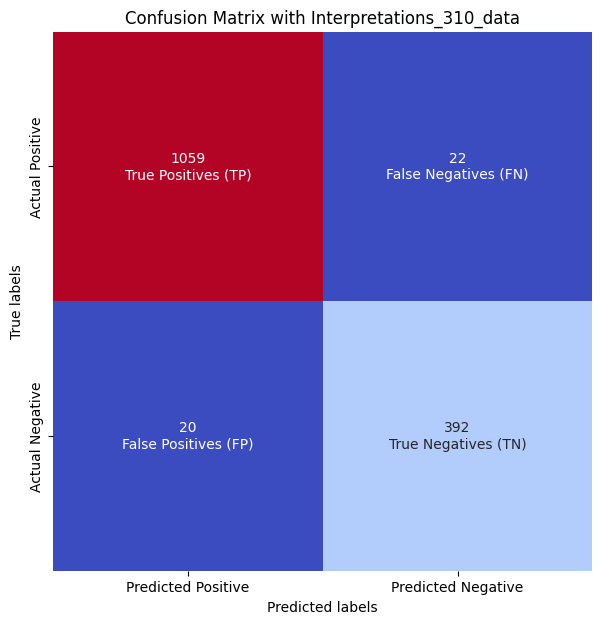

In [ ]:
conf_mat6 = confusion_matrix(y_test, y_pred_features6)

# Creating annotations with TP, TN, FP, FN labels
labels = np.array([['True Positives (TP)', 'False Negatives (FN)'],
                   ['False Positives (FP)', 'True Negatives (TN)']])
annot = np.asarray([f"{val}\n{labels[i, j]}" for i, j, val in zip(*conf_mat.nonzero(), conf_mat.flatten())]).reshape(2,2)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=annot, fmt='', cmap='coolwarm', cbar=False, square=True,
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Interpretations_310_data')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_features6))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3886
           1       0.85      0.65      0.74      1040

    accuracy                           0.90      4926
   macro avg       0.88      0.81      0.84      4926
weighted avg       0.90      0.90      0.90      4926



In [ ]:
# Define the cross-validation strategy
# Calculate cross-validated scores for the pipeline
cv_scores6 = cross_val_score(pipeline_df6, X_train, y_train, cv=3, scoring='f1')

# Print the mean F1 score and the 95% confidence interval of the score estimate
print("Mean CV F1 Score: %0.2f" % cv_scores6.mean())

Mean CV F1 Score: 0.74


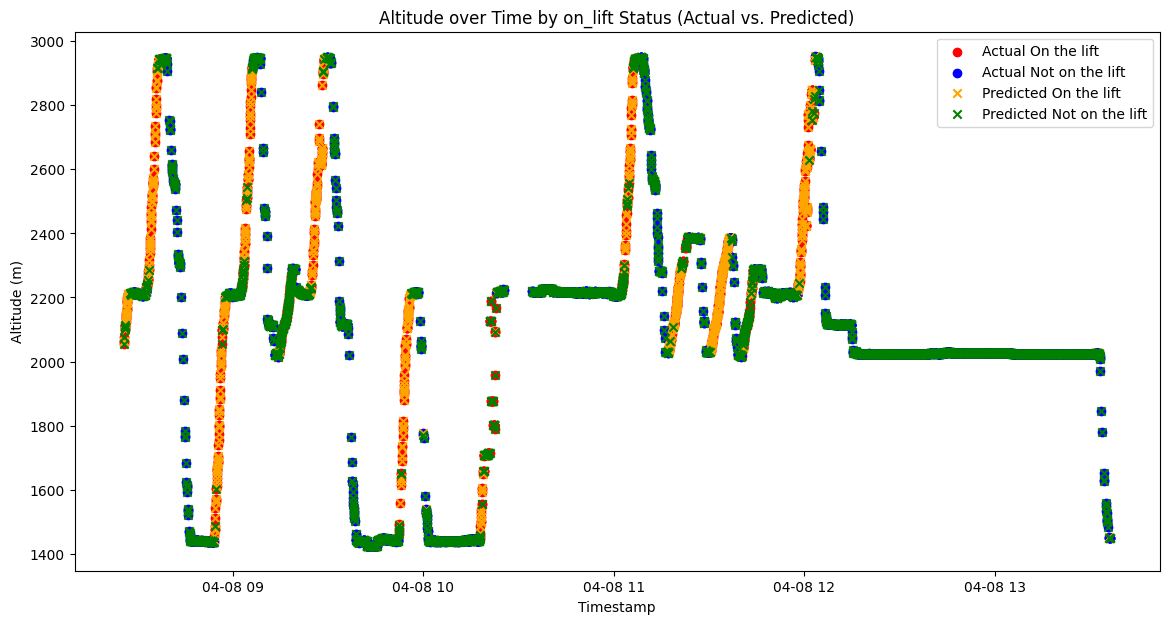

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))

# Actual on_lift values
plt.scatter(test_results_df.loc[test_results_df['on_lift'] == 1, 'Timestamp'],
            test_results_df.loc[test_results_df['on_lift'] == 1, 'Alt(m)'],
            c='red', label='Actual On the lift', marker='o')

plt.scatter(test_results_df.loc[test_results_df['on_lift'] == 0, 'Timestamp'],
            test_results_df.loc[test_results_df['on_lift'] == 0, 'Alt(m)'],
            c='blue', label='Actual Not on the lift', marker='o')

# Predicted on_lift values
plt.scatter(test_results_df.loc[test_results_df['Predicted'] == 1, 'Timestamp'],
            test_results_df.loc[test_results_df['Predicted'] == 1, 'Alt(m)'],
            c='orange', label='Predicted On the lift', marker='x')

plt.scatter(test_results_df.loc[test_results_df['Predicted'] == 0, 'Timestamp'],
            test_results_df.loc[test_results_df['Predicted'] == 0, 'Alt(m)'],
            c='green', label='Predicted Not on the lift', marker='x')

plt.title('Altitude over Time by on_lift Status (Actual vs. Predicted)')
plt.xlabel('Timestamp')
plt.ylabel('Altitude (m)')
plt.legend()
plt.show()
